In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

plt.rcParams['figure.figsize'] = (12, 12)
print(tf.__version__)

2.2.0


# Load the pretrained model

In [2]:
file = tf.keras.utils.get_file("model.h5",
                               "https://github.com/shoulderhu/0866007-ns-proj/blob/master/0866007_ns_proj6/model.h5?raw=true")
model = tf.keras.models.load_model(file)

# Load cat1.png, cat2.png, dog1.png

In [3]:
cls_list = ["cat", "dog"]

In [4]:
def preprocess(img):
    img = tf.keras.preprocessing.image.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = tf.convert_to_tensor(img)
    return img

In [5]:
loss_object = tf.keras.losses.CategoricalCrossentropy()

def create_adversarial_pattern(input_image, input_label):
    with tf.GradientTape() as tape:
        tape.watch(input_image)
        prediction = model(input_image)
        loss = loss_object(input_label, prediction)
    
    gradient = tape.gradient(loss, input_image)
    signed_grad = tf.sign(gradient)
    return signed_grad

In [6]:
def part1(i, png):
    file = tf.keras.utils.get_file(png, "https://raw.githuabusercontent.com/shoulderhu/0866007-ns-proj/master/0866007_ns_proj6/" + png)
    img = tf.keras.preprocessing.image.load_img(file, target_size=(224, 224))
    
    img = preprocess(img)
    pred = model.predict(img)
    top_inds = pred[0].argsort()[::-1][:5]
    
    plt.subplot(3, 3, i)
    plt.imshow(tf.cast(img[0], tf.uint8))
    plt.title("{} is {} ({:.3f})".format(png, cls_list[top_inds[0]], pred[0][top_inds[0]]))    
    return img, pred

In [7]:
def part2(i, index, img, pred): 
    label = tf.one_hot(index, pred.shape[-1])
    label = tf.reshape(label, (1, pred.shape[-1]))
    distortions = create_adversarial_pattern(img, label)
    
    plt.subplot(3, 3, i)
    plt.imshow(distortions[0] * 0.5 + 0.5)
    plt.title("")
    return distortions

In [8]:
def part3(i, eps, png, img, distortions):
    distortions = tf.math.multiply(distortions, 0.5)
    distortions = tf.math.add(distortions, 0.5)
    
    adv_x = img + eps * distortions * 255
    adv_x = tf.clip_by_value(adv_x, 0, 255) 
    pred = model.predict(adv_x)
    top_inds = pred[0].argsort()[::-1][:5]
    
    out = tf.keras.preprocessing.image.img_to_array(adv_x[0])
    tf.keras.preprocessing.image.save_img("adversarial_" + png, out)
    
    plt.subplot(3, 3, i)
    plt.imshow(tf.cast(adv_x[0], tf.uint8))
    plt.title("{} is {} ({:.3f})".format(png, cls_list[top_inds[0]], pred[0][top_inds[0]])) 

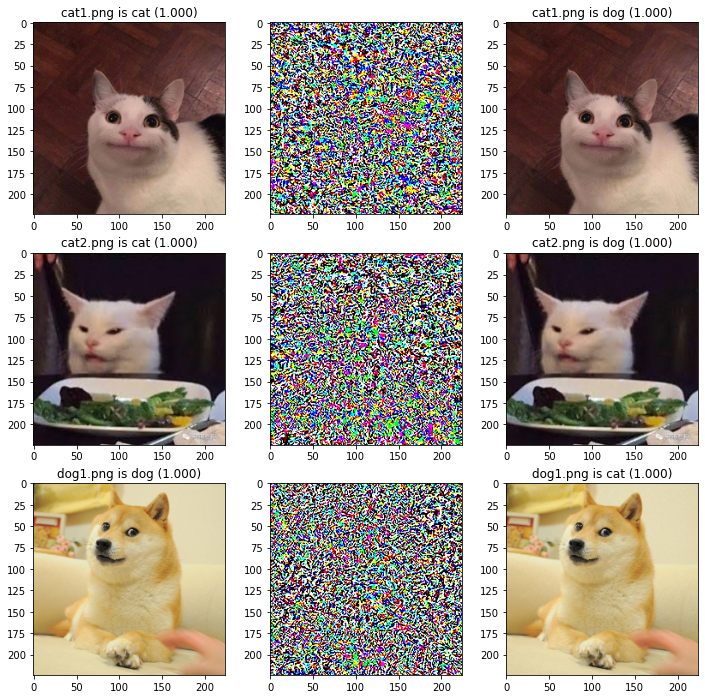

In [9]:
for i, png in enumerate(["cat1.png", "cat2.png", "dog1.png"]):
    img, pred = part1(3 * i + 1, png)
    
    if png[:3] == "cat":
        distortions = part2(3 * i + 2, 0, img, pred)
    else:
        distortions = part2(3 * i + 2, 1, img, pred)
    
    part3(3 * i + 3, 0.01, png, img, distortions)